In [2]:
import os
import pickle
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, GRU, Dense 
print('TensorFlow',tf.__version__)

TensorFlow 2.2.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=d34d36337e2c89ab860a9457a9f7aec014b030b627af992b60f733cb996a6ab5
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.6 GB  | Proc size: 376.7 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


## Loading the Dataset using tensorflow_datasets

In [0]:
NUM_SAMPLES = 800000
dataset = tfds.load(name='wmt14_translate/fr-en', as_supervised=True, download=False, data_dir="/content/drive/My Drive")
dataset['train'] = dataset['train'].take(NUM_SAMPLES)

## Adding Start and End Sequence Markers

In [6]:
en_sentences = []
fr_sentences = []
for example in tqdm(dataset['train']):
    en_sentences.append(example[0].numpy().decode())
    fr_sentences.append('startseq ' + example[1].numpy().decode() + ' endseq')
for example in tqdm(dataset['validation']):
    en_sentences.append(example[0].numpy().decode())
    fr_sentences.append('startseq ' + example[1].numpy().decode() + ' endseq')    

800000it [09:48, 1358.86it/s]
3000it [00:01, 1871.18it/s]


## Tokenization

In [0]:
en_tk = Tokenizer(num_words=30000)
fr_tk = Tokenizer(num_words=30000)
    
en_tk.fit_on_texts(en_sentences)
fr_tk.fit_on_texts(fr_sentences)    

## Visualizing Sequence Lengths

English sentences : mean = 28.572407222914073, std = 25.447013883755545, max = 5649
French sentences : mean = 26.94818181818182, std = 21.47389262720432, max = 3634


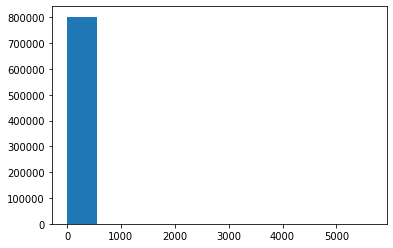

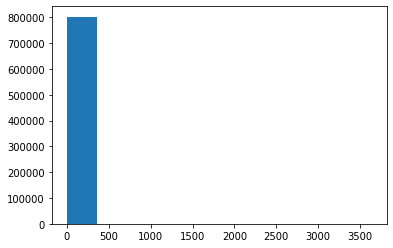

In [8]:
en_lens = [len(x.split()) for x in en_sentences]
fr_lens = [len(x.split()) for x in fr_sentences]

plt.figure()
plt.hist(en_lens)

plt.figure()
plt.hist(fr_lens)

en_mean = np.mean(en_lens)
en_std = np.std(en_lens)
fr_mean = np.mean(fr_lens)
fr_std = np.std(fr_lens)
en_max = np.max(en_lens)
fr_max = np.max(fr_lens)

print(f'English sentences : mean = {en_mean}, std = {en_std}, max = {en_max}')
print(f'French sentences : mean = {fr_mean}, std = {fr_std}, max = {fr_max}')

In [0]:
max_sequence_len = 30
en_vocab_size = 30000
fr_vocab_size = 30000

## Tokenization and Sequence Padding

In [0]:
def preprocess_en(en):
    encoded_en = en_tk.texts_to_sequences(en)
    padded_en = pad_sequences(encoded_en, maxlen=max_sequence_len, padding='post', truncating='post')
    return padded_en

def preprocess_fr(fr):
    encoded_fr = fr_tk.texts_to_sequences(fr)
    padded_fr = pad_sequences(encoded_fr, maxlen=max_sequence_len, padding='post', truncating='post')
    return padded_fr

def preprocess_text(en, fr):
    return preprocess_en(en.numpy().decode()), preprocess_fr(fr.numpy().decode())

## Preparing Training Dataset

In [11]:
train_ds = dataset['train']
train_en = []
train_fr = []
for example in tqdm(train_ds):
    train_en.append(example[0].numpy().decode())
    train_fr.append('startseq ' + example[1].numpy().decode() + ' endseq')
train_en = preprocess_en(train_en)
train_fr = preprocess_fr(train_fr)

batch_size = 80
train_dataset = tf.data.Dataset.from_tensor_slices((train_en, train_fr))
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(1024)
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

800000it [05:31, 2414.43it/s]


## Defining Encoder, Decoder, and Attention Models using tf.keras Model Subclassing

In [0]:
class Encoder(tf.keras.Model):
    def __init__(self, hidden_size=1000, max_sequence_len=30, batch_size=batch_size, embedding_dim=620, vocab_size=30000):
        super(Encoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.max_sequence_len = max_sequence_len
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.initializer = tf.keras.initializers.RandomNormal(mean=0, stddev=0.001)
        self.embedding_layer = Embedding(
            input_dim=self.vocab_size, output_dim=self.embedding_dim)
        self.GRU_1 = Bidirectional(GRU(units=hidden_size, return_sequences=True, return_state=True, kernel_initializer=self.initializer,
                                       bias_initializer='zeros'))

    def initial_hidden_state(self):
        return [tf.zeros(shape=(self.batch_size, self.hidden_size),) for i in range(2)]

    def call(self, x, initial_state, training=False):
        x = self.embedding_layer(x)
        x, hidden_state,_ = self.GRU_1(x, initial_state=initial_state)
        return x, hidden_state


class Attention(tf.keras.Model):
    def __init__(self, hidden_size=256):
        super(Attention, self).__init__()
        self.initializer = tf.keras.initializers.RandomNormal(mean=0, stddev=0.001)
        self.fc1 = Dense(units=hidden_size, kernel_initializer=self.initializer,
                                       bias_initializer='zeros')
        self.fc2 = Dense(units=hidden_size, kernel_initializer=self.initializer,
                                       bias_initializer='zeros')
        self.fc3 = Dense(units=1, kernel_initializer=self.initializer,
                                       bias_initializer='zeros')

    def call(self, encoder_output, hidden_state, training=False):
        '''hidden_state : h(t-1)'''
        y_hidden_state = tf.expand_dims(hidden_state, axis=1)
        y_hidden_state = self.fc1(y_hidden_state)
        y_enc_out = self.fc2(encoder_output)

        y = tf.keras.backend.tanh(y_enc_out + y_hidden_state)
        attention_score = self.fc3(y)
        attention_weights = tf.keras.backend.softmax(attention_score, axis=1)

        context_vector = tf.multiply(encoder_output, attention_weights)
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights


class Decoder(tf.keras.Model):
    def __init__(self, hidden_size=1000, max_sequence_len=30, batch_size=batch_size, embedding_dim=620, vocab_size=30000):
        super(Decoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.max_sequence_len = max_sequence_len
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.initializer = tf.keras.initializers.RandomNormal(mean=0, stddev=0.001)
        self.embedding_layer = Embedding(
            input_dim=self.vocab_size, output_dim=self.embedding_dim)
        self.GRU = GRU(units=hidden_size,
                       return_sequences=True, return_state=True)
        self.attention = Attention(hidden_size=self.hidden_size)
        self.fc = Dense(units=self.vocab_size, kernel_initializer=self.initializer,
                                       bias_initializer='zeros')

    def initial_hidden_state(self):
        return tf.zeros(shape=(self.batch_size, self.hidden_size))

    def call(self, x, encoder_output, hidden_state, training=False):
        x = self.embedding_layer(x)
        context_vector, attention_weights = self.attention(
            encoder_output, hidden_state, training=training)
        contect_vector = tf.expand_dims(context_vector, axis=1)
        x = tf.concat([x, contect_vector], axis=-1)
        x, curr_hidden_state = self.GRU(x)
        x = tf.reshape(x, shape=[self.batch_size, -1])
        x = self.fc(x)
        return x, curr_hidden_state, attention_weights

## Defining Training Loop, Loss Function and Optimizer

In [0]:
loss_object = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adadelta(rho=0.95, epsilon=1e-06)
train_accuracy = tf.metrics.SparseCategoricalAccuracy()


def loss_function(y_true, y_pred):
    loss = loss_object(y_true, y_pred)
    mask = 1 - tf.cast(tf.equal(y_true, 0), 'float32')
    return tf.reduce_mean(loss * mask)
    
@tf.function()
def training_step(en, fr):    
    with tf.GradientTape() as Tape:
        encoder_init_state = encoder.initial_hidden_state()
        encoder_output, encoder_hidden_state = encoder(en, encoder_init_state, training=True)
        decoder_hidden = encoder_hidden_state
        loss = 0
        acc = []
        current_word = tf.expand_dims(fr[:, 0], axis=1)
        for word_idx in range(1, max_sequence_len):
            next_word = fr[:, word_idx]
            logits, decoder_hidden, attention_weights = decoder(current_word, encoder_output, decoder_hidden, training=True)
            loss += loss_function(next_word, logits)
            acc.append(train_accuracy(next_word, logits))
            current_word = tf.expand_dims(next_word, axis=1)
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = Tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return loss, tf.reduce_mean(acc)

In [0]:
encoder = Encoder()
decoder = Decoder()
checkpoint_dir = '/content/drive/My Drive/training800000'
checkpoint_prefix = '/content/drive/My Drive/training800000/ckpt'
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

In [15]:
checkpoint.restore('/content/drive/My Drive/training800000/ckpt-7')

## Training the Model

In [16]:
epochs = 3
num_steps = NUM_SAMPLES // batch_size
for epoch in range(1, epochs + 1):
    print(f'Epoch {epoch}/{epochs}')
    ep_loss = []
    ep_acc = []
    progbar = tf.keras.utils.Progbar(target=num_steps, stateful_metrics=[
                                     'curr_loss', 'curr_accuracy'], unit_name='batch')

    for step, example in enumerate(train_dataset):
        en = example[0]
        fr = example[1]
        loss, acc = training_step(en, fr)
        loss /= fr.shape[1]
        ep_loss.append(loss)
        ep_acc.append(acc)
        progbar.update(
            step + 1, values=[('curr_loss', loss), ('curr_accuracy', acc)])

    checkpoint.save(file_prefix=checkpoint_prefix)
    print(checkpoint_prefix)
    print(f'Metrics after epoch {epoch} : Loss => {np.mean(ep_loss):.3f} | Accuracy => {np.mean(ep_acc):.3f}')
checkpoint.save(file_prefix=checkpoint_prefix)

Epoch 1/3
12500/12500 [==============================] - 5547s 444ms/batch - curr_loss: 1.3678 - curr_accuracy: 0.6535
/content/drive/My Drive/training800000/ckpt
Metrics after epoch 1 : Loss => 1.361 | Accuracy => 0.651
Epoch 2/3
12500/12500 [==============================] - 5502s 440ms/batch - curr_loss: 1.4663 - curr_accuracy: 0.6565
/content/drive/My Drive/training800000/ckpt
Metrics after epoch 2 : Loss => 1.320 | Accuracy => 0.655
Epoch 3/3
12500/12500 [==============================] - 5484s 439ms/batch - curr_loss: 1.3512 - curr_accuracy: 0.6596
/content/drive/My Drive/training800000/ckpt
Metrics after epoch 3 : Loss => 1.281 | Accuracy => 0.658


'/content/drive/My Drive/training800000/ckpt-11'

In [15]:
checkpoint.restore('/content/drive/My Drive/training800000/ckpt-10')

## Inference Function

In [0]:
def translate_sentence(sentence):
    sentence = preprocess_en([sentence])
    enc_init = tf.zeros(shape=[1, 1024])
    enc_out, enc_hidden = encoder(sentence, enc_init)

    decoder.batch_size = 1
    fr_tk.index_word[0] = ''
    decoded = []
    att = []
    current_word = tf.expand_dims([fr_tk.word_index['startseq']], axis=0) 
    decoder_hidden = enc_hidden
    for word_idx in range(1, max_sequence_len):
        logits, decoder_hidden, attention_weights = decoder(current_word, enc_out, decoder_hidden)
        decoded_idx = np.argmax(logits)
        if fr_tk.index_word[decoded_idx] == 'endseq':
            break
        decoded.append(fr_tk.index_word[decoded_idx])
        att.append(attention_weights.numpy().squeeze())
        current_word = tf.expand_dims([decoded_idx], axis=0)
    return ' '.join(decoded), att

## Translating and Visualizing Attention Maps

FR :  il y a un malentendu
EN :  there is a misunderstanding
------------------------------
FR :  que veux tu
EN :  what do you want
------------------------------
FR :  es tu fou
EN :  es tu
------------------------------
FR :  l'état de l'art
EN :  the state of art
------------------------------
FR :  l'examen est difficile
EN :  the review is difficult
------------------------------
FR :  voulez vous jouer avec moi
EN :  want me to play with me
------------------------------
FR :  je t'aime
EN :  i am
------------------------------
FR :  comment allez vous
EN :  how will you
------------------------------
FR :  je dois vous dire que je suis très dangereux
EN :  i must say that i am very dangerous
------------------------------
FR :  as tu une idée de comment l'utiliser
EN :  as you don’t see how to use it
------------------------------


<Figure size 360x288 with 0 Axes>

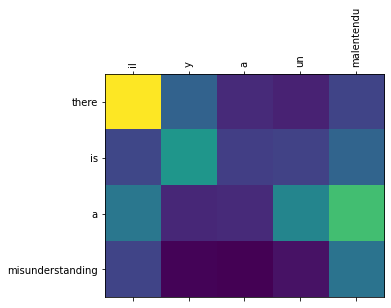

<Figure size 216x288 with 0 Axes>

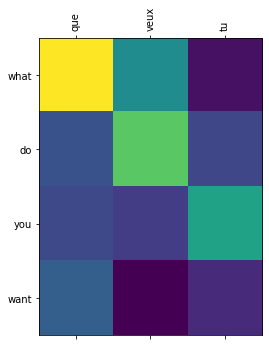

<Figure size 216x144 with 0 Axes>

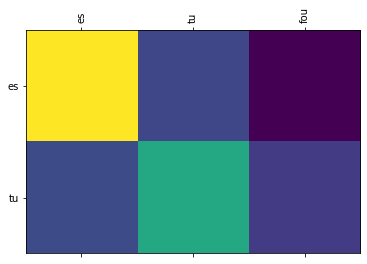

<Figure size 216x288 with 0 Axes>

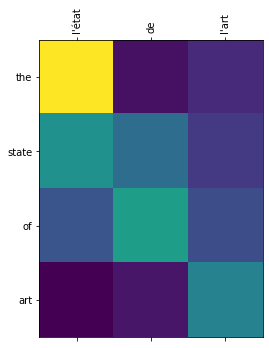

<Figure size 216x288 with 0 Axes>

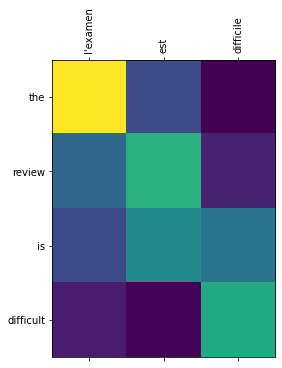

<Figure size 360x432 with 0 Axes>

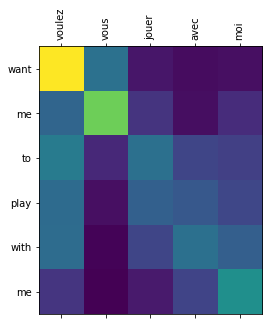

<Figure size 144x144 with 0 Axes>

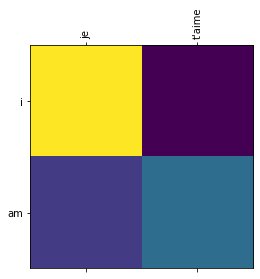

<Figure size 216x216 with 0 Axes>

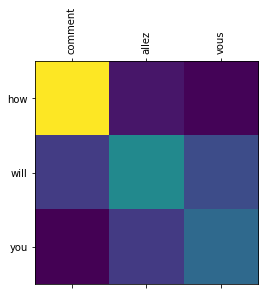

<Figure size 648x576 with 0 Axes>

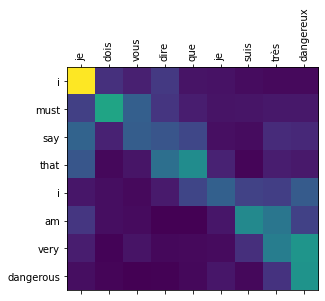

<Figure size 504x576 with 0 Axes>

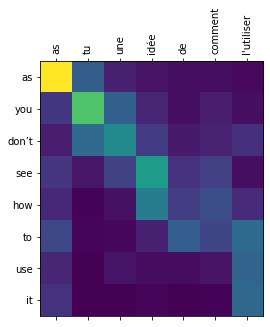

In [17]:
sentences = ["il y a un malentendu",
             'que veux tu',
             'es tu fou',
             "l'état de l'art",
             "l'examen est difficile", 
             'voulez vous jouer avec moi',
             "je t'aime",
             "comment allez vous",
             'je dois vous dire que je suis très dangereux',
             "as tu une idée de comment l'utiliser"]

for inp_sentence in sentences:
    inp_array = inp_sentence.split()
    inp_len = len(inp_sentence.split())
    trans_sentence, attention_weights = translate_sentence(inp_sentence)
    trans_array = trans_sentence.split()
    trans_len = len(trans_array)
    attention_weights = np.array([x for x in attention_weights])
    attention_weights = attention_weights[:trans_len,:inp_len]
    plt.figure(figsize=(inp_len, trans_len))
    plt.matshow(attention_weights)
    plt.xticks(ticks=range(inp_len), labels=inp_array, rotation=90)
    plt.yticks(ticks=range(trans_len), labels=trans_array)
    print('FR : ', inp_sentence)
    print('EN : ', trans_sentence)
    print('-'*30)